In [2]:
# Restart Kernel after running this.
!pip install shap==0.42.0


  Using cached shap-0.42.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (547 kB)
  Attempting uninstall: shap
    Found existing installation: shap 0.41.0
    Uninstalling shap-0.41.0:
      Successfully uninstalled shap-0.41.0

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Imports

In [1]:
import tensorflow as tf
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import seaborn as sns
import random
from random import sample
import pandas as pd
import json
import math
import pickle
import shap

2023-10-10 10:10:00.456494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 10:10:00.580571: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-10-10 10:10:00.580672: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-10-10 10:10:00.580896: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-1

In [2]:
try:
    import tensorflow.compat.v1 as tf 
    tf.disable_v2_behavior()
except:
    import tensorflow as tf

Instructions for updating:
non-resource variables are not supported in the long term


## Data Utility Functions

In [4]:
def get_data(test=False):
    hf = h5py.File('./../data/players_sample_data.h5', 'r')
    data_total = np.array(hf.get('x'))
    # data_total = data_total[:, :, :98]
    endpoints_total = np.array(hf.get('y'))
    hf.close()
    
    data_train, data_val, y_train, endpoints_total_val = train_test_split(data_total,
                                                                          endpoints_total,
                                                                          test_size=0.15,
                                                                          random_state=42)
    if test:
        data_val = data_total[int(len(data_total) * 0.85):]
        endpoints_total_val = endpoints_total[int(len(data_total) * 0.85):]
    return data_train, y_train, data_val, endpoints_total_val
    

In [5]:
def batch_generator(data_train, endpoints_total_train, data_val, endpoints_total_val, batch_size, mode="train"):
    """Generator for the data batches.
        Args:
            data_train: training set.
            data_val: validation/test set.
            labels_val: labels of the validation set.
            batch_size (int): Batch size for the training.
            mode (str): Mode in ['train', 'val', 'test'] that decides which data set the generator
                samples from (default: 'train').
        Yields:
            np.array: Data batch.
            np.array: Labels batch.
            int: Offset of the batch in dataset.
    """
    while True:
        if mode == "train": # training data is 80% of the 85%, batches are more, batch size would be the same as the validation
            for i in range(len(data_train) // batch_size):
                time_series = data_train[i * batch_size: (i + 1) * batch_size]
                time_series_endpoint = endpoints_total_train[i * batch_size: (i + 1) * batch_size]
                yield time_series, time_series_endpoint, i
        elif mode == "val": # val data is 20% of the 85%, batches are less, batch size would be the same as the validation
            for i in range(len(data_val) // batch_size):
                time_series = data_val[i * batch_size: (i + 1) * batch_size]
                time_series_endpoint = endpoints_total_val[i * batch_size: (i + 1) * batch_size]
                yield time_series, time_series_endpoint, i
        else:
            raise ValueError("The mode has to be in {train, val}")



In [6]:
def z_dist_flat(z_e, embeddings, config):
    """Computes the distances between the encodings and the embeddings."""
    som_dim = config['som_dim']
    latent_dim = config['latent_dim']
    emb = np.reshape(embeddings, (som_dim[0]*som_dim[1], -1))
    z = np.reshape(z_e, (z_e.shape[0], 1, latent_dim))
    z = np.tile(z, [1,som_dim[0]*som_dim[1], 1])
    z_dist = np.square(z-emb)
    z_dist_red = np.sum(z_dist, axis=-1)
    return z_dist_red

## Configurations

In [7]:
config = {
    'ex_name': "hyperopt_LSTM_100_8-8_2023-09-22_10291",
    'som_dim': [8,8],
    'latent_dim': 100,
    'batch_size': 50,
    'max_n_step': 7,
    'num_pred': 6,
    'lstm_dim': 200,
    'input_size': 19,
    'trans_mat_size': 49,
    'c_dim': 3
}

feature_name_dict = {
0:'Playtime_in_minutes', 1:'cat', 2:'cat_amount', 3:'cpc', 4:'cpc_size2', 5:'cpc_size6', 
6:'total_games', 7:'fgl_2_player', 8:'fgl_6_player', 9:'total_modes', 10:'total_transactions',
11:'net_gain', 12:'lng', 13:'drop_count', 14:'invalid_dec_count', 15:'drop_adhere_count', 
16:'acf', 17:'acf_amount', 18:'dld' 
}

modelpath = "../models/{}/{}".format(config['ex_name'], config['ex_name'])

modelpath

'../models/hyperopt_LSTM_100_8-8_2023-09-22_10291/hyperopt_LSTM_100_8-8_2023-09-22_10291'

In [8]:
data_train_full, endpoints_total_train_full, data_val_full, endpoints_total_val_full = get_data(test=True)

data_train, endpoints_total_train, data_val, endpoints_total_val = get_data(test=True)
data_train = data_train[:,:config['max_n_step'], :]
data_val = data_val[:,:config['max_n_step'], :]
endpoints_total_train = endpoints_total_train[:,:config['max_n_step'], :]
endpoints_total_val = endpoints_total_val[:,:config['max_n_step'], :]
    

## Interpretability

In [9]:
# Step 1
actual_risky_data_val = []
actual_risky_endpoints_total_val = []
actual_risky_data_index = []

for i in range(len(endpoints_total_train_full)):
    if 1 in endpoints_total_train_full[i][:,54]:
        actual_risky_data_index.append(i)
        actual_risky_data_val.append(data_train_full[i])
        actual_risky_endpoints_total_val.append(endpoints_total_train_full[i])
actual_risky_data_val = np.array(actual_risky_data_val)
actual_risky_endpoints_total_val = np.array(actual_risky_endpoints_total_val)

print(len(actual_risky_data_val)) 




150


In [10]:
def retrieve_clusters_and_labels(data_x, data_y, config):

    batch_gen = batch_generator(data_x, data_y, data_x, data_y, config['batch_size'], mode="train")
    num_batches = len(data_x) // config['batch_size']
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(modelpath+".meta")
        saver.restore(sess, modelpath)
        graph = tf.get_default_graph()

        k = graph.get_tensor_by_name("k/k:0")
        x = graph.get_tensor_by_name("inputs/x:0")
        x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
        concat_x_c = graph.get_tensor_by_name("concatenated_inputs/concat_x_c:0")

        test_k_all = []
        labels_all = []

        for i in range(num_batches):
            batch_data, batch_labels, ii = next(batch_gen)
            batch_val_ts_data = batch_data[ :, :, config['trans_mat_size']:]
            batch_trans_mat_x = batch_data[ :, :, :config['trans_mat_size']]
            
            batch_conditions = np.zeros((batch_val_ts_data.shape[0], batch_val_ts_data.shape[1], config['c_dim']))
            batch_concat_x_c = np.concatenate((batch_val_ts_data, batch_conditions), axis=2)
            
            f_dic = {x: batch_val_ts_data, 
                     x_trans_mat: batch_trans_mat_x,
                    concat_x_c: batch_concat_x_c}
            test_k_all.extend(sess.run(k, feed_dict=f_dic))
            labels_all.extend(batch_labels)
        k_all = np.array(test_k_all)
        labels_all = np.array(labels_all)
        
    return k_all, labels_all

### Cluster-Map

In [11]:
k_all, labels_all_clustr = retrieve_clusters_and_labels(data_train, endpoints_total_train, config)
k_all.shape

2023-10-10 10:10:14.910566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:14.916644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:14.917235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:14.918480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate com

INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTM_100_8-8_2023-09-22_10291/hyperopt_LSTM_100_8-8_2023-09-22_10291


(88550,)

In [12]:
clusters, freq_counts = np.unique(k_all, return_counts=True)
som_dim = config['som_dim']
for i in range(som_dim[0]):
    op_str=""
    for j in range(som_dim[1]):
        op_str += str(clusters[i*som_dim[0]+j]) + ":" + str(freq_counts[i*som_dim[0]+j]) + "   "
    print(op_str)


0:579   1:827   2:1541   3:3109   4:1478   5:767   6:382   7:742   
8:518   9:835   10:916   11:3157   12:2953   13:1110   14:509   15:1004   
16:1100   17:796   18:747   19:1237   20:1569   21:1966   22:1670   23:843   
24:1361   25:697   26:788   27:585   28:1000   29:1739   30:3443   31:902   
32:3474   33:965   34:240   35:721   36:825   37:1039   38:1796   39:1689   
40:1840   41:1018   42:847   43:1124   44:905   45:804   46:1562   47:2684   
48:3825   49:1969   50:1734   51:960   52:782   53:1503   54:1591   55:1489   
56:2944   57:1304   58:1975   59:1061   60:1596   61:1630   62:682   63:1102   


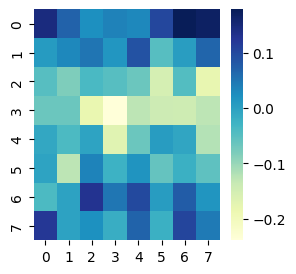

In [13]:
labels_all_clustr = np.reshape(labels_all_clustr, (-1, labels_all_clustr.shape[-1]))
risk_score_label = labels_all_clustr[:,57]
# time_segments = time_segments.astype(int)
# labels = time_segments
som_dim = config['som_dim']
f = plt.figure(figsize=(3,3))
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(risk_score_label[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
plt.show()

### Trajectories

In [14]:
def retrieve_conditions(data_x, data_y, config):

    batch_gen = batch_generator(data_x, data_y, data_x, data_y, config['batch_size'], mode="train")
    num_batches = len(data_x) // config['batch_size']
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(modelpath+".meta")
        saver.restore(sess, modelpath)
        graph = tf.get_default_graph()

        x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
        conditions_op = graph.get_tensor_by_name("condition_pred_y/conditions_one_hot:0")
        
        cond_all = []
        for i in range(num_batches):
            batch_data, batch_labels, ii = next(batch_gen)
            batch_trans_mat_x = batch_data[ :, :, :config['trans_mat_size']]

            f_dic = { x_trans_mat: batch_trans_mat_x}
            cond_all.extend(sess.run(conditions_op, feed_dict= f_dic))
        cond_all = np.array(cond_all)
    return cond_all


In [15]:
k_full_all, labels_full_all = retrieve_clusters_and_labels(data_val_full, endpoints_total_val_full, config)
cond_full_all = retrieve_conditions(data_val_full, endpoints_total_val_full, config)

k_full_all = np.reshape(k_full_all, (-1, config['max_n_step']+config['num_pred']))
labels_full_all = np.reshape(labels_full_all, (-1, labels_full_all.shape[-1]))
cond_full_all = np.argmax(cond_full_all, axis=1)
cond_full_all = np.reshape(cond_full_all, (-1, config['max_n_step']+config['num_pred']))


risk_y_label = labels_full_all[:,54]
risk_y_label = risk_y_label.astype(int)

2023-10-10 10:10:22.335144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:22.335770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:22.336137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:22.336542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:22.336885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTM_100_8-8_2023-09-22_10291/hyperopt_LSTM_100_8-8_2023-09-22_10291


2023-10-10 10:10:25.803735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:25.804261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:25.804614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:25.805021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:10:25.805385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTM_100_8-8_2023-09-22_10291/hyperopt_LSTM_100_8-8_2023-09-22_10291


In [16]:
H = []
R = []

h = np.reshape(risk_y_label, (-1,config['max_n_step']+config['num_pred']))
for i in range(len(h)):
    if np.max(h[i]) == 1:
        R.append(i)
    else:
        H.append(i)

def find_total_distance(k_arr):        
    td=0
    for i in range(len(k_arr)-1):
        x1 = k_arr[i] // som_dim[0]
        y1 = k_arr[i] % som_dim[0]
        x2 = k_arr[i+1] // som_dim[0]
        y2 = k_arr[i+1] % som_dim[0]
        td+=math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return td
        
def retrieve_top_healthy_players(k_full_all, H):
    op=[]
    for ind in H:
        k_arr = k_full_all[ind]
        td = find_total_distance(k_arr)
        op.append([ind, td])
    return sorted(op, key = lambda x: x[1])

def retrieve_top_risky_players(k_full_all, R):
    op=[]
    for ind in R:
        k_arr = k_full_all[ind]
        td = find_total_distance(k_arr)
        op.append((ind, td))
    return sorted(op, key = lambda x: x[1])


filtered_healthy_players = retrieve_top_healthy_players(k_full_all, H)
filtered_healthy_players = filtered_healthy_players[:9]

filtered_risky_players = retrieve_top_risky_players(k_full_all, R)
# filtered_risky_players = filtered_risky_players[]
print(len(filtered_risky_players))

9


In [17]:

ind_h = [tup[0] for tup in filtered_healthy_players]
ind_r = [tup[0] for tup in filtered_risky_players]

H = np.array(ind_h)
R = np.array(ind_r)
a = np.concatenate([H, R])
a

array([1986, 1800,  441,  222, 1897, 1631, 2040,  618, 1636,  854, 1400,
       1516, 1308,  336,  416, 1189, 1263,  809])

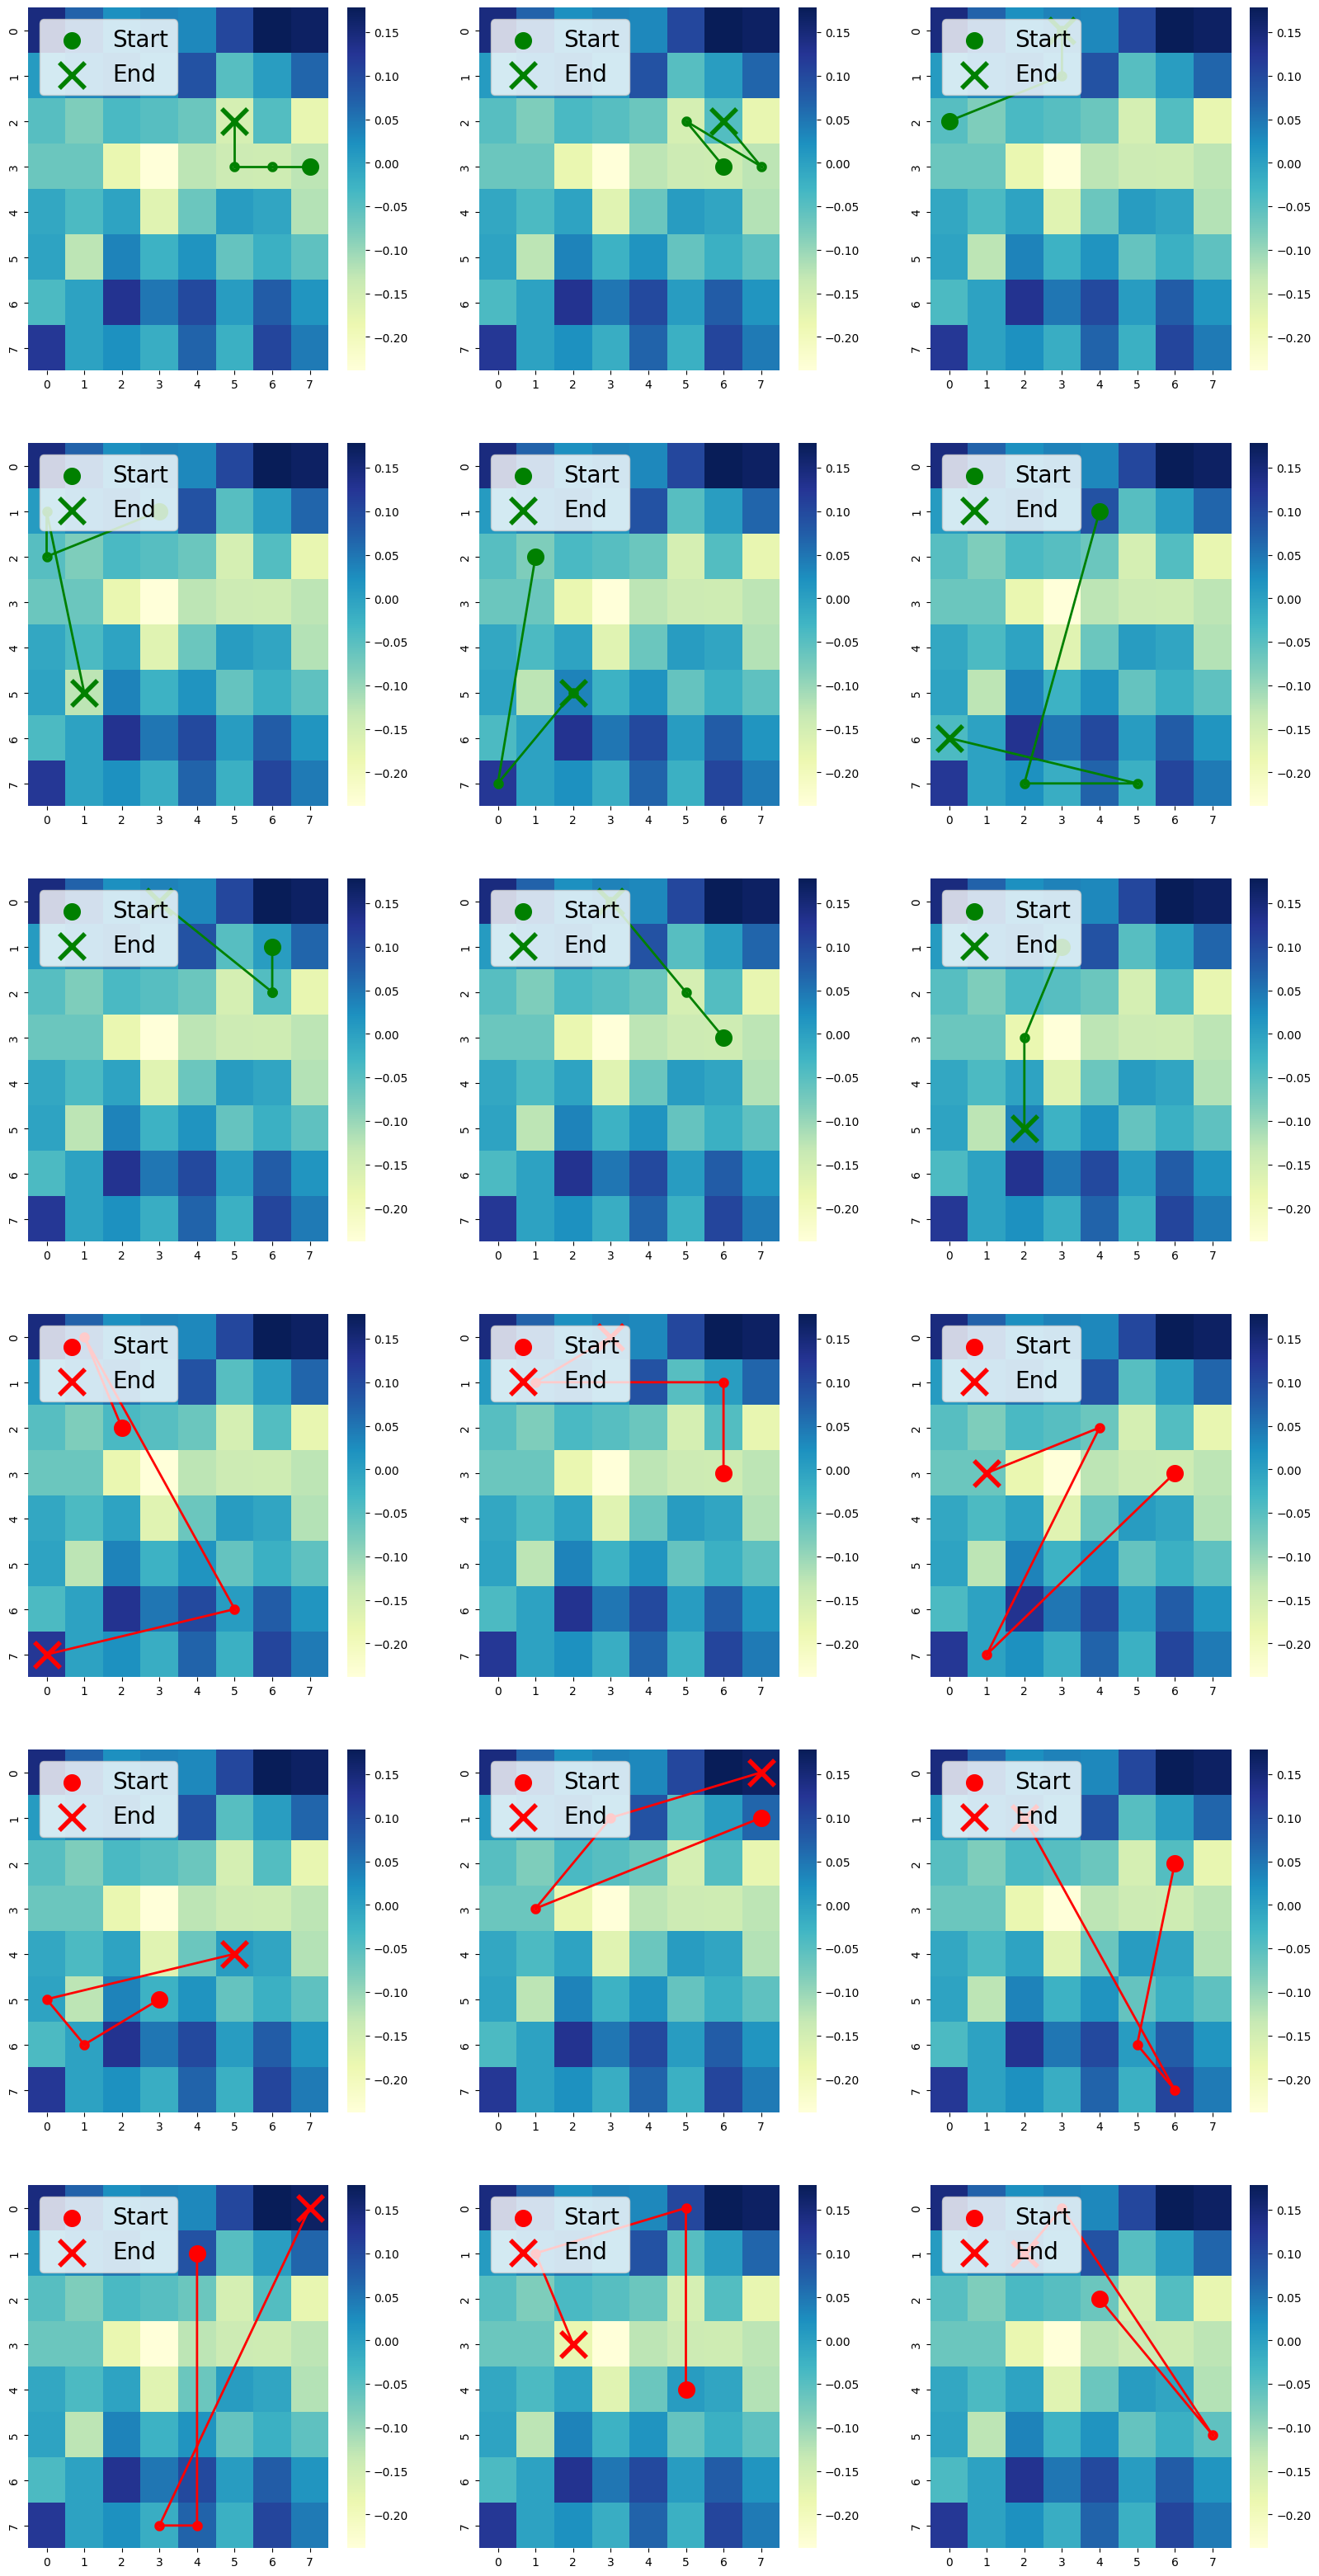

In [18]:
it = 0
fig, ax = plt.subplots(6, 3, figsize=(20,40)) 

for t in a:
    if it >= len(H):
        c = "r"
    else:
        c = "g"
    cc = it % 3
    rr = it // 3
    # print(t, rr, cc)
    g = sns.heatmap(clust_matr1, cmap="YlGnBu",ax=ax[rr][cc])
    k_1 = k_full_all[t, -4:] // som_dim[1]
    k_2 = k_full_all[t, -4:] % som_dim[1]
    cond_list = cond_full_all[t, -8:]

    # print(k_1.shape)
    ax[rr][cc].plot(k_2[:6] + 0.5, k_1[:6] + 0.5, color=c, linewidth=2)
    ax[rr][cc].plot(k_2[5:] + 0.5, k_1[5:] + 0.5, color=c, linestyle='dashed', linewidth=2)
    
    ax[rr][cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=200, label='Start')
    ax[rr][cc].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=6, marker='.')
    # for i, cond in enumerate(cond_list):
    #     ax[rr][cc].annotate(cond, (k_2[i]+0.3, k_1[i]+0.2), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))
    
    ax[rr][cc].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker='x', label='End')
    ax[rr][cc].legend(loc=2, prop={'size': 20})
    it +=1

plt.show()

## Explainability

### Cluster-definitions

In [35]:
def model_cluster_inference(input_data):
    
    # Set Configurations
    modepath = "../models/hyperopt_LSTM_100_8-8_2023-09-22_10291/hyperopt_LSTM_100_8-8_2023-09-22_10291"
    latent_dim = 100
    max_n_step = 7
    lstm_dim = 200
    c_dim = 3
    trans_mat_size = 49
    input_size = 19
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(modelpath + ".meta")
        saver.restore(sess, modelpath)
        
        graph = tf.get_default_graph()
        
        k = graph.get_tensor_by_name("k/k:0")
        x = graph.get_tensor_by_name("inputs/x:0")
        x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
        
        ts_data = np.expand_dims(input_data[:, trans_mat_size:], axis=0 )
        trans_mat_x_data = np.expand_dims(input_data[:, :trans_mat_size], axis=0 )
        
        k_all = []
        f_dic = {x: ts_data, x_trans_mat:trans_mat_x_data}
        k_all = sess.run(k, feed_dict=f_dic)

    return k_all
    

In [ ]:
input_data = np.reshape(data_train, (-1, data_train.shape[2]))
k_all = model_cluster_inference(input_data)

In [ ]:
class_explanations = []
for class_label in np.unique(k_all):
    print("class_label:", class_label)
    class_mask = (k_all == class_label)
    filtered_input = input_data[class_mask]    
    sampled_input = filtered_input[np.random.choice(filtered_input.shape[0], 10, replace=False)]

    explainer = shap.Explainer(model_cluster_inference, sampled_input)
    shap_values = explainer.shap_values(sampled_input)
    class_explanations.append(shap_values)
    

In [ ]:
# Save the shapley values.

# Option:1
pickle_file_path = '../data/class_explanations.pkl'
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(class_explanations, pickle_file)
print(f'Explanations saved to {pickle_file_path}')

# Option:2
class_explanations_nparray = np.array(class_explanations)
with open('../data/class_explanations.npy', 'wb') as f:
    np.save(f, class_explanations_nparray)

In [ ]:
# Load the shapley values.

# Option:2
class_explanations = np.load('../data/class_explanations.npy')
class_explanations.shape

In [ ]:
# Generate the feature importance for each cluster

cluster_feat_imp = {}
for i in range(len(class_explanations)):
    sv_cls = class_explanations[i]
    mean_sv = np.mean(sv_cls[:, config['trans_mat_size']:], axis=0)
    most_imp_feature = feature_name_dict[np.abs(mean_sv).argmax()]
    cluster_feat_imp[i] = most_imp_feature

In [ ]:
# Save the cluster signature features

# Option:1
pickle_file_path = '../data/cluster_signature.pkl'
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(cluster_feat_imp, pickle_file)
print(f'Cluster signatures are saved to {pickle_file_path}')



## Cluster-explanations Visualisation

In [19]:
def get_imp_feature_from_cluster():
    f = open("../data/cluster_signature.pkl", "rb")
    return pickle.load(f)

cluster_imp_feat = get_imp_feature_from_cluster()
significant_clusters_list = list(cluster_imp_feat.values())

In [20]:
sig_cluster_map =[["" for j in range(config['som_dim'][1])] for i in range(config['som_dim'][1])]
for i in range(config['som_dim'][0]):
    for j in range(config['som_dim'][1]):
        sig_cluster_map[i][j] = significant_clusters_list[i*config['som_dim'][1] + j]

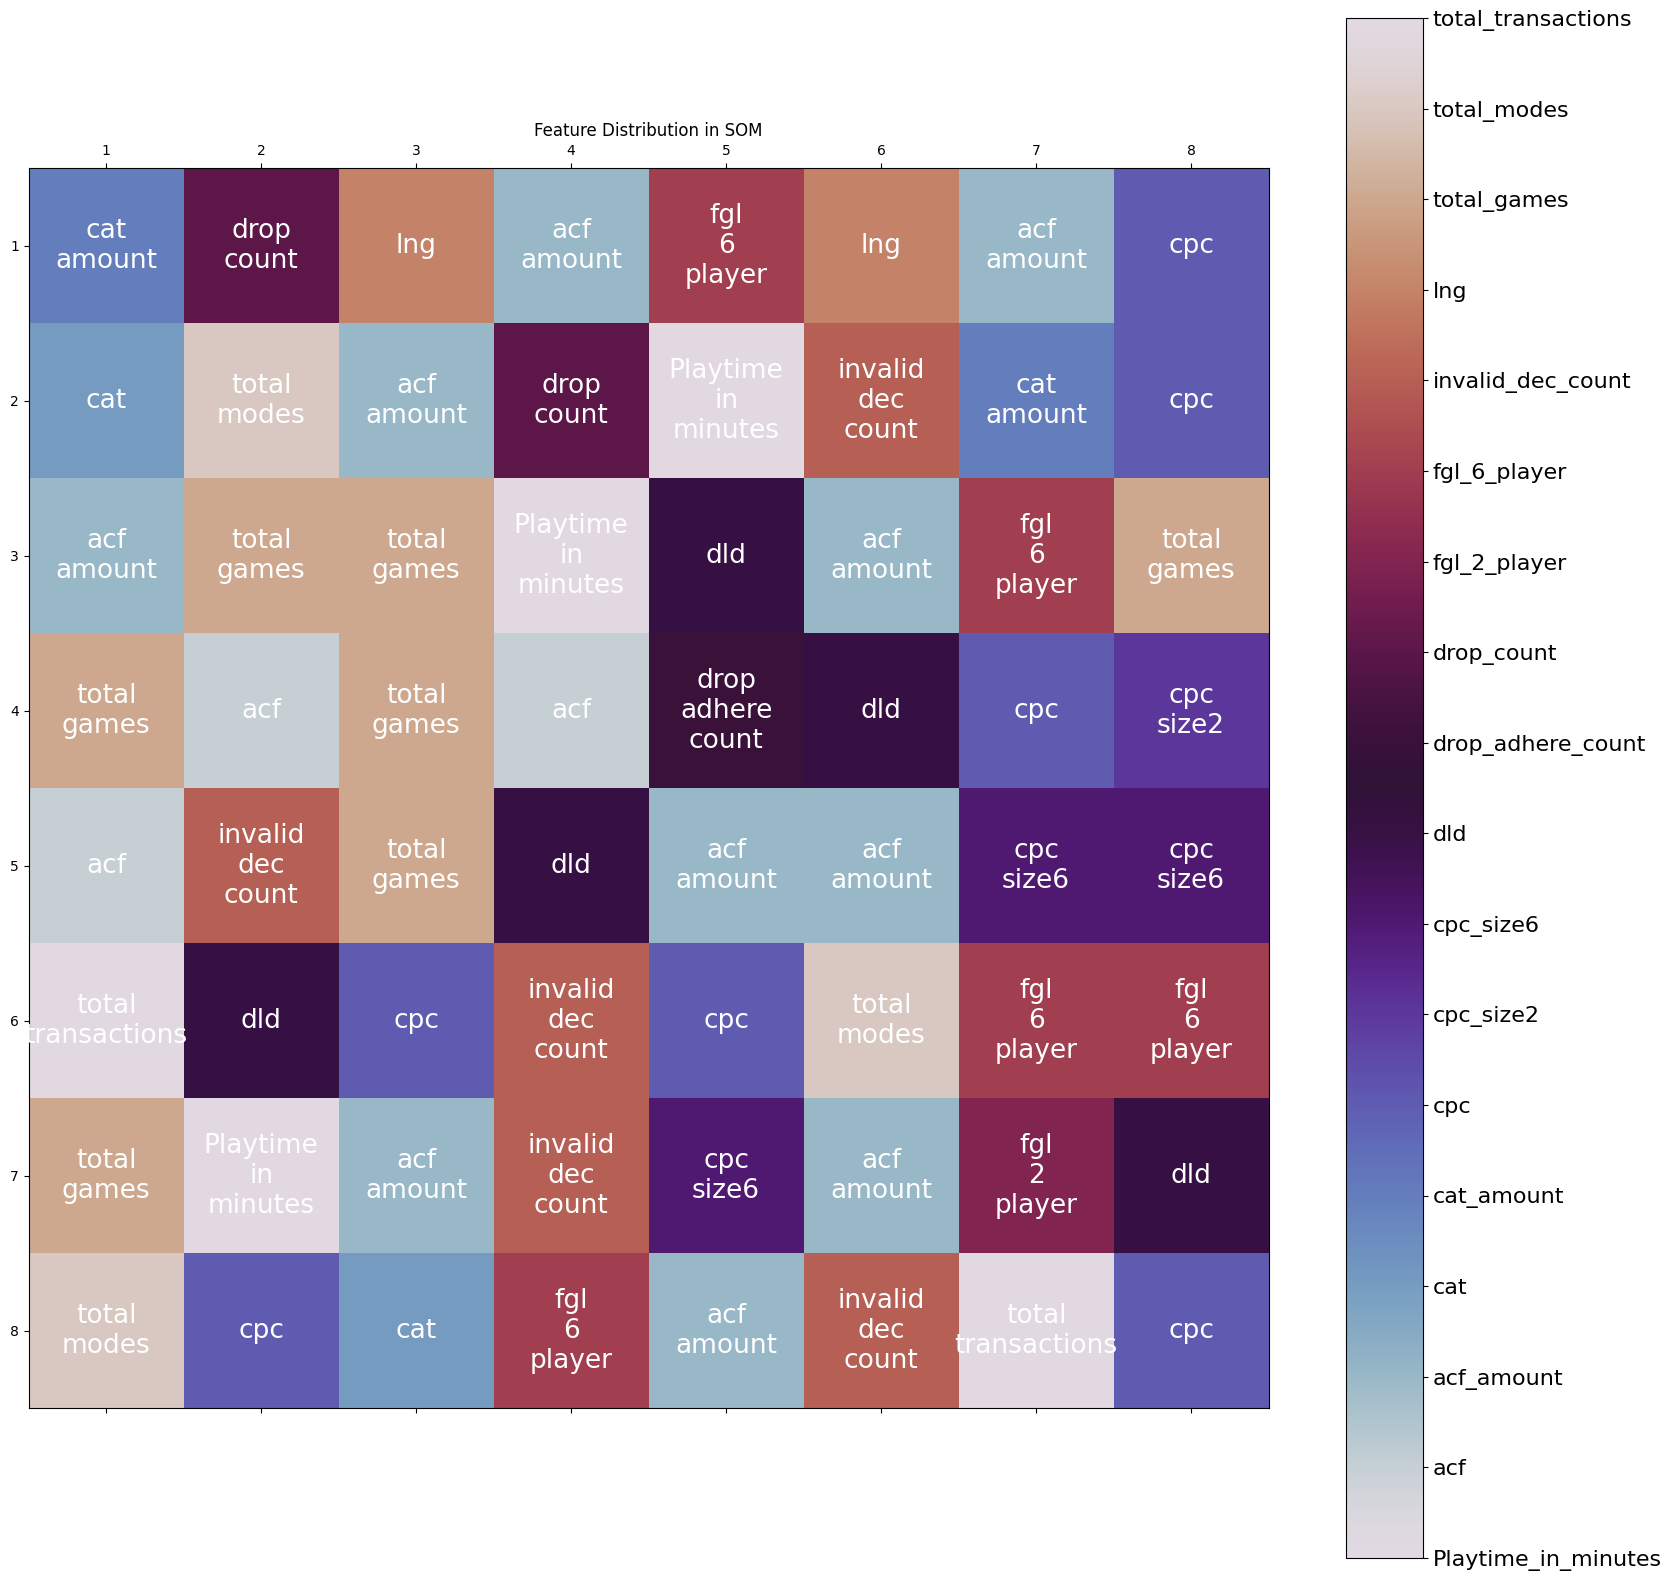

In [25]:
# Create a mapping of labels to unique integers
label_map = {label: i for i, label in enumerate(np.unique(np.array(sig_cluster_map)))}

# Convert data to numerical values using the mapping
numerical_data = np.array([[label_map[label] for label in row] for row in sig_cluster_map])

# fig, ax = plt.subplots(5, 4, figsize=(40,40)) 

fig, ax = plt.subplots(figsize = (20,20))

# Create heatmap
cax = ax.matshow(numerical_data, cmap='twilight' )

# Add colorbar
cbar = fig.colorbar(cax)

# Annotate the colorbar with values from data
cbar.set_ticks(np.arange(numerical_data.min(), numerical_data.max() + 1))
cbar.set_ticklabels(np.unique(np.array(sig_cluster_map)))
cbar.ax.tick_params(labelsize=16)

# # Add colorbar
# fig.colorbar(cax)

# Set labels
ax.set_xticks(range(len(sig_cluster_map[0])))
ax.set_yticks(range(len(sig_cluster_map)))
ax.set_xticklabels(range(1, len(sig_cluster_map[0]) + 1))
ax.set_yticklabels(range(1, len(sig_cluster_map) + 1))


# Annotate the cells with their values
for i in range(len(sig_cluster_map)):
    for j in range(len(sig_cluster_map[0])):
        ax.text(j, i, "\n".join(sig_cluster_map[i][j].split('_')), ha='center', va='center', color='white', fontsize=19 )#if numerical_data[i, j] > 8 else 'black')

        
# Show plot
plt.title('Feature Distribution in SOM')
plt.show()

## Derive Explanation Report for TP Players

In [57]:
# Run this function only after running Explanability Module.
def get_imp_feature_from_cluster():
    f = open("../data/cluster_signature.pkl", "rb")
    return pickle.load(f)

    
def derive_explanation_reports(data_set_list, index_for_cluster, index_for_ground_truth, modelpath, config):
    """Derives explanations reports.

        Args:
            model (T-DPSOM): Trained T-DPSOM model to evaluate.
            x (tf.Tensor): Input tensor or placeholder.
            val_gen (generator): Val/Test generator for the batches.
            modelpath (path): Path from which to restore the model.
            batch_size (int): Batch size for the training.
            latent_dim (int): Dimensionality of the T-DPSOM's latent space.
            num_pred (int): No of timestamps for predictions.
            
        Returns:
            dict: Explanation Reports for TP players
        """
    
    data_train_full, endpoints_total_train_full, data_val_full, endpoints_total_val_full = data_set_list
    som_dim = config['som_dim']
    latent_dim = config['latent_dim']
    batch_size = config['batch_size']
    max_n_step = config['max_n_step']
    num_pred = config['num_pred']
    lstm_dim = config['lstm_dim']
    input_size = config['input_size']
    trans_mat_size = config['trans_mat_size']
    c_dim = config['c_dim']
    
    data_train = data_train_full[:, :max_n_step, :]
    endpoints_total_train = endpoints_total_train_full[:, :max_n_step, :]
    data_val = data_val_full[:, :max_n_step, :]
    endpoints_total_val = endpoints_total_val_full[:, :max_n_step, :]
    
    train_gen = batch_generator(data_train, endpoints_total_train, data_val, endpoints_total_val, batch_size, mode="train")
    val_gen = batch_generator(data_train, endpoints_total_train, data_val, endpoints_total_val, batch_size, mode="val")
    tf.reset_default_graph()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(modelpath + ".meta")
        saver.restore(sess, modelpath)
        
        graph = tf.get_default_graph()
        
        k = graph.get_tensor_by_name("k/k:0")
        z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
        x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
        y_trans_mat = graph.get_tensor_by_name("y_trans_mat_inputs/y_trans_mat:0")
        is_training = graph.get_tensor_by_name("is_training/is_training:0")
        
        next_z_e = graph.get_tensor_by_name("prediction/next_z_e:0")
        x = graph.get_tensor_by_name("inputs/x:0")
        init_1 = graph.get_tensor_by_name("prediction/next_state/init_state:0")
        z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
        state1 = graph.get_tensor_by_name("prediction/next_state/next_state:0")
        q = graph.get_tensor_by_name("q/distribution/q:0")
        embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
        z_p = graph.get_tensor_by_name('reconstruction_e/decoder/z_e:0')
        reconstruction = graph.get_tensor_by_name("reconstruction_e/x_hat:0")
        c = graph.get_tensor_by_name("conditions/c:0")
        concat_x_c = graph.get_tensor_by_name("concatenated_inputs/concat_x_c:0")
        trans_mat_op = graph.get_tensor_by_name("shift_x_trans_mat/trans_mat_op:0")
        conditions_op = graph.get_tensor_by_name("condition_pred_y/conditions_one_hot:0")
        attention_weights = graph.get_tensor_by_name("prediction/next_state/attention_weights:0")

        
        #############################################################################
        #  I. Evaluating whole training data to generate heat map cluster matrix    #
        #############################################################################
        
        # -------------------------------------------- #
        # 1. Find all k_all of the full training data  #
        # -------------------------------------------- #
        
        num_batches = len(data_train) // batch_size
        training_dic = {is_training: False, z_e_p: np.zeros((max_n_step, len(data_train), latent_dim)),
                        init_1: np.zeros((2, batch_size, lstm_dim)), 
                        z_p: np.zeros((max_n_step * len(data_train), latent_dim + c_dim))}
        k_all = []
        labels_all = []
        for i in range(num_batches):
            batch_data, batch_labels, ii = next(train_gen)

            #Added for CVAE
            batch_ts_data = batch_data[ :, :, trans_mat_size:]
            batch_trans_mat_x = batch_data[:, :, :trans_mat_size]
            batch_trans_mat_y = batch_labels[:, :, :trans_mat_size]
            labels_all.extend(batch_labels)

            batch_conditions = np.zeros((batch_ts_data.shape[0], max_n_step, c_dim))
            batch_concat_x_c = np.concatenate((batch_ts_data, batch_conditions), axis=2)
            f_dic = {x: batch_ts_data, x_trans_mat:batch_trans_mat_x, y_trans_mat:batch_trans_mat_y, c:batch_conditions, concat_x_c: batch_concat_x_c}            
            k_all.extend(sess.run(k, feed_dict=f_dic))

        k_all = np.array(k_all)
        k_all = k_all.reshape((-1, max_n_step))
        labels_all = np.array(labels_all)
        labels_all = np.reshape(labels_all, (-1, labels_all.shape[-1]))
        
        
        print("k_all.shape:", k_all.shape)
        print("labels_all.shape:", labels_all.shape)

        
        # --------------------------------------------------------------------------- #
        #  2. Generate Heatmap cluster matrix for all cluster generated till this step   #
        # --------------------------------------------------------------------------- #
        
        labels = labels_all[:,index_for_cluster]
        print(k_all)
        ones = np.ones((len(np.reshape(k_all, (-1)))))
        clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
        clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
        for i in range(som_dim[0]*som_dim[1]):
            s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
            clust_matr1[i] = s1
            
        flat_aggr_clust_matr1 = clust_matr1
        non_nan_clustr_matr = flat_aggr_clust_matr1[~np.isnan(flat_aggr_clust_matr1)]
        decile_array = np.percentile(non_nan_clustr_matr, np.arange(0, 100, 10))
        # threshold_n = decile_array[-2]
        threshold_n = 0.0

        print("flat_aggr_clust_matr1:\n", flat_aggr_clust_matr1)
        print("threshold_n:", threshold_n)
        
        
        ######################################################################
        #  II. Evaluating whole validation data and generating all arrays    #
        ######################################################################
        
        num_batches = len(data_val) // batch_size
        total_val_size = num_batches * batch_size
        training_dic = {is_training: True, z_e_p: np.zeros((max_n_step, len(data_val), latent_dim)),
                        init_1: np.zeros((2, batch_size, lstm_dim)), 
                        z_p: np.zeros((max_n_step * len(data_val), latent_dim + c_dim))}
        
        k_all = []
        z_e_all=[]
        for i in range(num_batches):
            batch_val_data, batch_val_labels, ii = next(val_gen)

            #Added for CVAE
            batch_val_ts_data = batch_val_data[ :, :, trans_mat_size:]
            batch_val_trans_mat_x = batch_val_data[:, :, :trans_mat_size]
            batch_val_trans_mat_y = batch_val_labels[:, :, :trans_mat_size]

            batch_conditions = np.zeros((batch_val_ts_data.shape[0], max_n_step, c_dim))
            batch_concat_x_c = np.concatenate((batch_val_ts_data, batch_conditions), axis=2)
            f_dic = {x: batch_val_ts_data, x_trans_mat:batch_val_trans_mat_x, y_trans_mat:batch_val_trans_mat_y, c:batch_conditions, concat_x_c: batch_concat_x_c}            

            k_all.extend(sess.run(k, feed_dict=f_dic))
            z_e_all.extend(sess.run(z_e, feed_dict=f_dic))

        z_e_all = np.array(z_e_all)
        k_all = np.array(k_all)

        z_e_all = z_e_all.reshape((-1, max_n_step, latent_dim))
        k_all = k_all.reshape((-1, max_n_step))

        
        
        #####################################################################################
        #  III. Generate embeddings for validation data till (max_n_step - num_pred) step   #
        #####################################################################################   
        embeddings = sess.run(embeddings, feed_dict={x: data_val[:, :max_n_step, trans_mat_size:]})
        embeddings = np.reshape(embeddings,(-1, latent_dim))

        z_e_o = z_e_all[:, :max_n_step, :]
        k_o = k_all[:, :max_n_step]
        next_z_e_o = []
        state1_o = []
        attention_weights_list = []
        attention_weights_for_all_at_t = []
        for i in range(num_batches):
            batch_val_data, _, ii = next(val_gen)
            batch_val_data=batch_val_data[:, :max_n_step, :]
            
            #Added for CVAE
            batch_val_ts_data = batch_val_data[ :, :, trans_mat_size:]
            batch_val_trans_mat_x = batch_val_data[:, :, :trans_mat_size]
            batch_conditions = np.zeros((batch_val_ts_data.shape[0], max_n_step, c_dim))
            batch_concat_x_c = np.concatenate((batch_val_ts_data, batch_conditions), axis=2)
            f_dic = {x: batch_val_ts_data, x_trans_mat: batch_val_trans_mat_x, c:batch_conditions, concat_x_c: batch_concat_x_c}
            f_dic.update(training_dic)
        
            next_z_e_o.extend(sess.run(next_z_e, feed_dict=f_dic))
            attention_weights_for_all_at_t.extend(sess.run(attention_weights, feed_dict=f_dic))

            if i == 0:
                state1_o = sess.run(state1, feed_dict=f_dic)
            else:
                state1_o = np.concatenate([state1_o, sess.run(state1, feed_dict=f_dic)], axis=1)
        next_z_e_o = np.array(next_z_e_o)
        state1_o = np.array(state1_o)
        next_z_e_o_all = np.reshape(next_z_e_o, (-1, max_n_step, latent_dim))
        k_next = np.argmin(z_dist_flat(next_z_e_o[:, -1, :], embeddings, config), axis=-1)
        k_o = np.concatenate([k_o, np.expand_dims(k_next,1)], axis=1)
        
        # Added for attention explainations.
        attention_weights_for_all_at_t = np.array(attention_weights_for_all_at_t)
        attention_weights_list.append(attention_weights_for_all_at_t)
        attention_weights_list = np.array(attention_weights_list)

        ###########################################################################
        #  IV. Updated pred with sliced data and embeddings for each timestamp.   #
        ###########################################################################
        for i in range(num_pred-1):
            inp = data_val_full[:total_val_size, i:(max_n_step + i), trans_mat_size:]
            inp_trans = data_val_full[:total_val_size, i:(max_n_step + i), :trans_mat_size]
            
            batch_conditions = np.zeros((inp.shape[0], max_n_step, c_dim))
            batch_concat_x_c = np.concatenate((inp, batch_conditions), axis=2)

            f_dic = {x: inp, x_trans_mat: inp_trans}
            val_dic = {is_training: False, z_e_p: next_z_e_o, init_1: state1_o,
                       z_p: np.zeros((max_n_step * len(inp), latent_dim + c_dim)),
                       c:batch_conditions, concat_x_c: batch_concat_x_c}
            f_dic.update(val_dic)
            next_z_e_o = sess.run(next_z_e, feed_dict=f_dic)
            state1_o = sess.run(state1, feed_dict=f_dic)
            k_next = np.argmin(z_dist_flat(next_z_e_o[:, -1, :], embeddings, config), axis=-1)
            k_o = np.concatenate([k_o, np.expand_dims(k_next,1)], axis=1)
                        
                
            # Storing Attention Weights for each prediction.
            attention_weights_o = sess.run(attention_weights, feed_dict=f_dic)
            # print("attention_weights_o.shape", attention_weights_o.shape)
            attention_weights_list = np.concatenate([attention_weights_list, np.expand_dims(attention_weights_o,0)], axis=0)     
            # print("attention_weights_list.shape", attention_weights_list.shape)
                
            next_z_e_o_all = np.concatenate([next_z_e_o_all,  np.reshape(next_z_e_o[:, -1, :], (next_z_e_o[:, -1, :].shape[0], 1, next_z_e_o[:, -1, :].shape[1]) )], axis=1)
            next_z_e_o = next_z_e_o_all[:, i+1:, :]
        
        k_o_pred = k_o[:, max_n_step:]
        
                
        ###############################################
        #  V. Caluclate cluster index threshold list  #
        ###############################################
        full_val_aggr_threshold_lists = []
        full_val_rgp_initiated_flag_lists =[] 
        for ind, user_k in enumerate(k_o_pred):
            full_val_aggr_user_cluster_score = [flat_aggr_clust_matr1[k] for k in user_k]
            full_val_aggr_threshold = [1 if val>=threshold_n else 0 for val in full_val_aggr_user_cluster_score]
            full_val_aggr_threshold_lists.append(full_val_aggr_threshold)
            full_val_rgp_initiated_flags = endpoints_total_val_full[ind][max_n_step:,index_for_ground_truth]
            full_val_rgp_initiated_flag_lists.append(full_val_rgp_initiated_flags)
   

        ##########################
        # VI. Define Persistency #
        ##########################
        burst_threshold=2
        def check_persistency_validation(threshold, ground_flag_list):
            last_rgp_flag_ind = np.where(ground_flag_list==8)[0][-1] 
            # Definition 1 of Persistency in model => 3 times occurance in darker zone less than equal to rgp date.
            # occ_count = 0
            # for i in range(last_rgp_flag_ind, -1, -1):
            #     if threshold[i]==1:
            #         occ_count+=1
            #     if occ_count==3:
            #         return True
            # return False

            # Definition 2 of Persistency in model => A burst of more than 2 occurance in darker zone.
            occ_count = 0
            for i in range(last_rgp_flag_ind+1):
                if threshold[i]==1:
                    occ_count+=1
                else:
                    occ_count=0

                if occ_count>=burst_threshold:
                    return True
            return False
        
        
        ###############################
        #  VII. Derive Explainability #
        ###############################
        def find_burst_start_and_end(threshold):
            occ_count = 0
            burst_start = -1
            burst_end = -1
            for i in range(num_pred):
                if threshold[i]==1:
                    occ_count+=1
                    if burst_start==-1:
                        burst_start=i
                else:
                    occ_count=0
                    burst_start=-1
                    
                if occ_count>=burst_threshold:
                    burst_end = i
                    return [burst_start, burst_end]
        
        
        def find_most_attentive_index(player_i, burst_start, burst_end):
            # Considering Last step reponsible for the transition to a risky state and excluding self attention.
            b_start_attention_map = attention_weights_list[burst_start, player_i, :-1, -1]
            b_end_attention_map = attention_weights_list[burst_end, player_i, :-1, -1]
            return np.argmax(b_start_attention_map)+burst_start, np.argmax(b_end_attention_map)+burst_end
            
        
        def derive_explainability(threshold_lists, ground_flag_flists):
            predicted_risky = 0
            predicted_n_actual_risky = 0
            predicted_risky_explainations = []
            cluster_imp_feat = get_imp_feature_from_cluster()
            for i, threshold in enumerate(threshold_lists):
                temp =[0 for ii in range(len(threshold))]
                temp[-1]=8
                temp=np.array(temp)
                if check_persistency_validation(threshold, temp):
                    predicted_risky+=1
                    burst_start, burst_end = find_burst_start_and_end(threshold)
                    ai_for_burst_start, ai_for_burst_end = find_most_attentive_index(i, burst_start, burst_end)
                    attentive_cluster_for_burst_start = k_o[i, ai_for_burst_start]
                    attentive_cluster_for_burst_end = k_o[i, ai_for_burst_end]
                    predicted_risky_explainations.append(
                        {
                            'index':i,
                            'burst_start_index':int(max_n_step+burst_start),
                            'burst_end_index':int(max_n_step+burst_end),
                            'attentive_index_for_burst_start':int(ai_for_burst_start),
                            'attentive_index_for_burst_end':int(ai_for_burst_end),
                            'attentive_cluster_for_burst_start':int(attentive_cluster_for_burst_start),
                            'attentive_cluster_for_burst_end':int(attentive_cluster_for_burst_end),
                            'max_feature_imp_for_burst_start': cluster_imp_feat[attentive_cluster_for_burst_start],
                            'max_feature_imp_for_burst_end': cluster_imp_feat[attentive_cluster_for_burst_end],
                        }
                    )
            return predicted_risky_explainations
        
        exp_report = derive_explainability(full_val_aggr_threshold_lists, full_val_rgp_initiated_flag_lists)
        return exp_report

In [58]:
data_train_full, endpoints_total_train_full, data_val_full, endpoints_total_val_full = get_data(test=True)

exp_report = derive_explanation_reports([data_train_full, endpoints_total_train_full, data_val_full, endpoints_total_val_full], 57, 53, modelpath, config )

2023-10-10 10:46:35.655422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:46:35.655982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:46:35.656344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:46:35.656723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 10:46:35.657054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTM_100_8-8_2023-09-22_10291/hyperopt_LSTM_100_8-8_2023-09-22_10291
k_all.shape: (12650, 7)
labels_all.shape: (88550, 58)
[[47 58 32 ... 53 55 49]
 [ 5 24 51 ... 56 54 39]
 [ 2 30 52 ... 59 15 26]
 ...
 [ 7 29  5 ... 47 18 38]
 [12 43 52 ... 26 32 42]
 [32 58 38 ...  2 28 32]]
flat_aggr_clust_matr1:
 [ 0.14430095  0.07044616  0.02338504  0.0366811   0.03160941  0.10328776
  0.17827509  0.16750502  0.00866058  0.03068667  0.04958382  0.01456528
  0.08735998 -0.04871061  0.00447038  0.0659061  -0.0485062  -0.08210755
 -0.03726367 -0.04873721 -0.0647716  -0.15277003 -0.0455542  -0.17882064
 -0.06477019 -0.06466289 -0.18271648 -0.23885751 -0.12759249 -0.14174552
 -0.1436274  -0.12797044 -0.0095959  -0.03847137 -0.00315673 -0.16798583
 -0.06578502  0.00653411 -0.00611275 -0.12016773 -0.00264653 -0.12690102
  0.03492415 -0.02452456  0.01783107 -0.06104764 -0.02120914 -0.05500749
 -0.03974208 -0.00139145  0.1281943   0.04926221  0.

In [11]:
# exp_report

# Option:1
pickle_file_path = './data/explainable_reports/exp_report_'+config['ex_name']+'.pkl'
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(exp_report, pickle_file)
print(f'Forecasting Results with explainantions are saved to {pickle_file_path}')

Forecasting Results with explainantions are saved to ./data/explainable_reports/exp_report_hyperopt_LSTM_100_8-8_2023-09-22_10291.pkl


## Case Study - I

### Config


In [35]:
pid = 336
max_n_step = 5
num_pred = 2
total_length = 13

### Trajectory

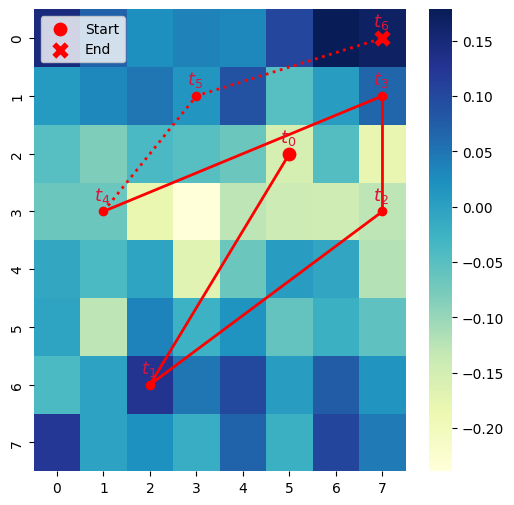

In [36]:
f = plt.figure(figsize=(6,6))

ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
k_1 = k_full_all[pid, -(max_n_step+num_pred):] // som_dim[1]
k_2 = k_full_all[pid, -(max_n_step+num_pred):] % som_dim[1]
cond_list = cond_full_all[pid, -(max_n_step+num_pred):]
# c='#8C000F'
c='r'

# Plotting solid line for input data
ax.plot(k_2[:max_n_step] + 0.5, k_1[:max_n_step] + 0.5, color=c, linewidth=2)

# Plotting dashed line for predition
ax.plot(k_2[-(num_pred+1):] + 0.5, k_1[-(num_pred+1):] + 0.5, color=c, linestyle='dotted', linewidth=2)

# Plotting Start, Intermediate and End Points
ax.scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=80, label='Start')
ax.scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=4, marker='.')
ax.scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=80, linewidth=4, marker='x', label='End')

# Plotting the state transitions
for i in range(max_n_step+num_pred):
    ax.annotate('$t_{'+str(i)+'}$', (k_2[i]+0.3, k_1[i]+0.3), fontsize=13, color='crimson' ,fontweight='bold')
    

ax.legend(loc=2, prop={'size': 10})
plt.show()


### Explanability

#### 1. Attention over time_steps

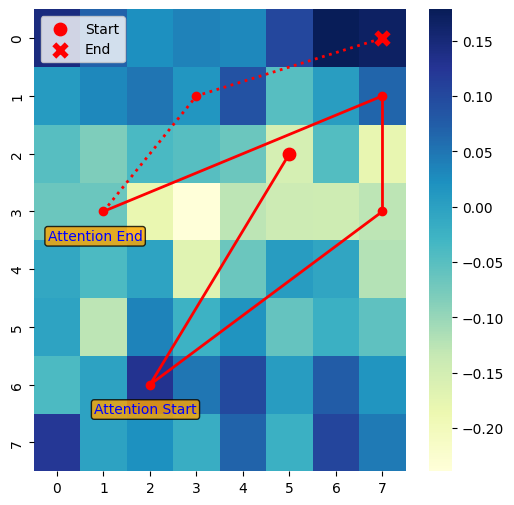

In [37]:
exp_report_for_pid = {}
for item in exp_report:
    if item['index']==pid:
        exp_report_for_pid.update(item)

ai_bs = exp_report_for_pid['attentive_index_for_burst_start']
ai_be = exp_report_for_pid['attentive_index_for_burst_end']

f = plt.figure(figsize=(6,6))

ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
k_1 = k_full_all[pid, -(max_n_step+num_pred):] // som_dim[1]
k_2 = k_full_all[pid, -(max_n_step+num_pred):] % som_dim[1]
cond_list = cond_full_all[pid, -(max_n_step+num_pred):]
c='r'

# Plotting solid line for input data
ax.plot(k_2[:max_n_step] + 0.5, k_1[:max_n_step] + 0.5, color=c, linewidth=2)

# Plotting dashed line for predition
ax.plot(k_2[-(num_pred+1):] + 0.5, k_1[-(num_pred+1):] + 0.5, color=c, linestyle='dotted', linewidth=2)

# Plotting Start, Intermediate and End Points
ax.scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=80, label='Start')
ax.scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=4, marker='.')
ax.scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=80, linewidth=4, marker='x', label='End')

# Plotting indexes for attention over TS.
ax.annotate("Attention Start", (k_2[ai_bs - (num_pred+max_n_step)]-1+0.3, k_1[ai_bs - (num_pred+max_n_step)]+1), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))
ax.annotate("Attention End", (k_2[ai_be - (num_pred+max_n_step-2)]-1+0.3, k_1[ai_be - (num_pred+max_n_step-2)]+1), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))

ax.legend(loc=2, prop={'size': 10})
plt.show()

#### 2. State Transitions


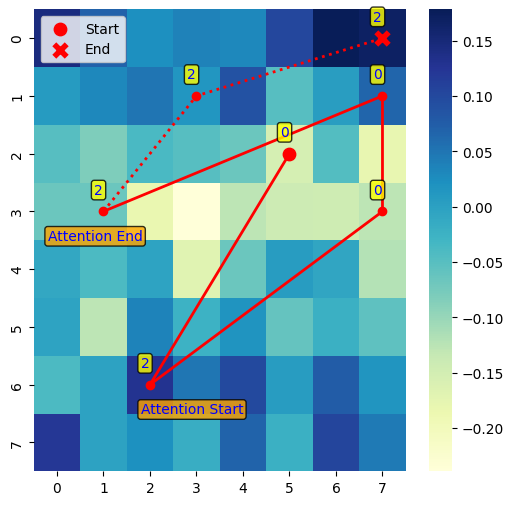

In [38]:
exp_report_for_pid = {}
for item in exp_report:
    if item['index']==pid:
        exp_report_for_pid.update(item)

ai_bs = exp_report_for_pid['attentive_index_for_burst_start']
ai_be = exp_report_for_pid['attentive_index_for_burst_end']

f = plt.figure(figsize=(6,6))

ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
k_1 = k_full_all[pid, -(max_n_step+num_pred):] // som_dim[1]
k_2 = k_full_all[pid, -(max_n_step+num_pred):] % som_dim[1]

cond_list = cond_full_all[pid, :-max_n_step+1]
cond_list = cond_list[ -(max_n_step+num_pred):]

c='r'

# Plotting solid line for input data
ax.plot(k_2[:max_n_step] + 0.5, k_1[:max_n_step] + 0.5, color=c, linewidth=2)

# Plotting dashed line for predition
ax.plot(k_2[-(num_pred+1):] + 0.5, k_1[-(num_pred+1):] + 0.5, color=c, linestyle='dotted', linewidth=2)

# Plotting Start, Intermediate and End Points
ax.scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=80, label='Start')
ax.scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=4, marker='.')
ax.scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=80, linewidth=4, marker='x', label='End')


# Plotting the state transitions
for i, cond in enumerate(cond_list):
    ax.annotate(cond, (k_2[i]+0.3, k_1[i]+0.2), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.8))
    

# Plotting indexes for attention over TS.
ax.annotate("Attention Start", (k_2[ai_bs - (num_pred+max_n_step)]+0.3, k_1[ai_bs - (num_pred+max_n_step)]+1), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))
ax.annotate("Attention End", (k_2[ai_be - (num_pred+max_n_step-2)]-1+0.3, k_1[ai_be - (num_pred+max_n_step-2)]+1), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))

ax.legend(loc=2, prop={'size': 10})
plt.show()

#### 3. Features Responsible

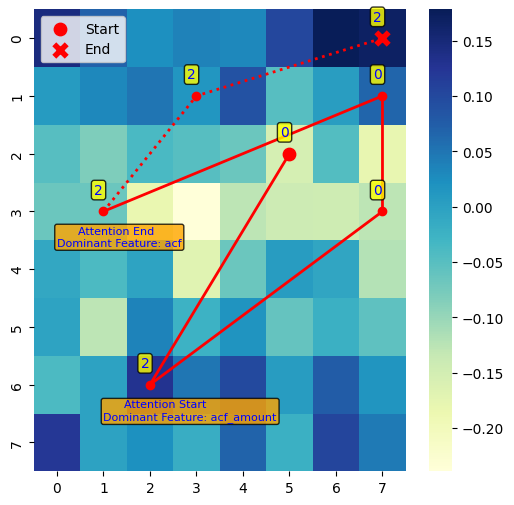

In [39]:
exp_report_for_pid = {}
for item in exp_report:
    if item['index']==pid:
        exp_report_for_pid.update(item)

cluster_imp_feat = get_imp_feature_from_cluster()
ai_bs = exp_report_for_pid['attentive_index_for_burst_start']
ai_be = exp_report_for_pid['attentive_index_for_burst_end']

f = plt.figure(figsize=(6,6))

ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
k_1 = k_full_all[pid, -(max_n_step+num_pred):] // som_dim[1]
k_2 = k_full_all[pid, -(max_n_step+num_pred):] % som_dim[1]

cond_list = cond_full_all[pid, :-max_n_step+1]
cond_list = cond_list[ -(max_n_step+num_pred):]

c='r'

# Plotting solid line for input data
ax.plot(k_2[:max_n_step] + 0.5, k_1[:max_n_step] + 0.5, color=c, linewidth=2)

# Plotting dashed line for predition
ax.plot(k_2[-(num_pred+1):] + 0.5, k_1[-(num_pred+1):] + 0.5, color=c, linestyle='dotted', linewidth=2)

# Plotting Start, Intermediate and End Points
ax.scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=80, label='Start')
ax.scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=4, marker='.')
ax.scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=80, linewidth=4, marker='x', label='End')

# Plotting the state transitions
for i, cond in enumerate(cond_list):
    ax.annotate(cond, (k_2[i]+0.3, k_1[i]+0.2), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.8))

att_start_k = k_full_all[pid, ai_bs - 1] 
att_end_k = k_full_all[pid, ai_be + 1]

# Plotting Import features for  attentitive clusters.
ax.annotate("      Attention Start\nDominant Feature: "+cluster_imp_feat[att_start_k], (k_2[ai_bs - (num_pred+max_n_step)]-0.5, k_1[ai_bs - (num_pred+max_n_step)]+1.1), color='blue', fontsize=8, bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8,))
ax.annotate("      Attention End\nDominant Feature: "+cluster_imp_feat[att_end_k], (k_2[ai_be - (num_pred+max_n_step-2)]-0.5, k_1[ai_be - (num_pred+max_n_step-2)]+1.1), color='blue', fontsize=8, bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))

ax.legend(loc=2, prop={'size': 10})
plt.show()

#### 4. Dominant Features graphs across timesteps 

In [41]:
feature_name_dict

{0: 'Playtime_in_minutes',
 1: 'cat',
 2: 'cat_amount',
 3: 'cpc',
 4: 'cpc_size2',
 5: 'cpc_size6',
 6: 'total_games',
 7: 'fgl_2_player',
 8: 'fgl_6_player',
 9: 'total_modes',
 10: 'total_transactions',
 11: 'net_gain',
 12: 'lng',
 13: 'drop_count',
 14: 'invalid_dec_count',
 15: 'drop_adhere_count',
 16: 'acf',
 17: 'acf_amount',
 18: 'dld'}

In [42]:
cluster_imp_feat = get_imp_feature_from_cluster()

for i in range(config['input_size']):
    
    features_data = data_val_full[pid, -(max_n_step+num_pred):, config['trans_mat_size']+i]
    # Repective indexes for Dominant Features (acf_amount & acf)
    if i==17:
        print("Attention start point")
        x1 = features_data
        print(x1)
    if i==16:
        print("Attention end point")
        x2 = features_data
        print(x2)
        
        
# print(x1, x2)

Attention end point
[0.269 0.233 0.181 0.16  0.387 0.323 0.269]
Attention start point
[0.349 0.877 0.181 0.16  0.387 0.323 0.659]


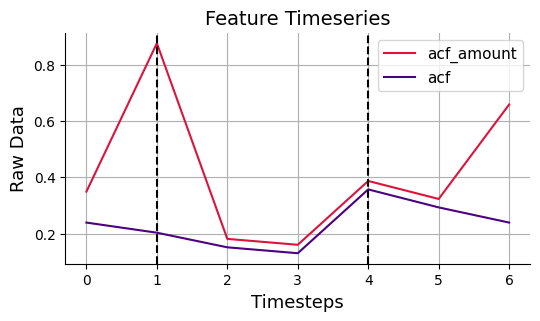

In [44]:
plt.figure(figsize=(6,3))
                    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axis('off')
plt.plot(x1, color='crimson', label='acf_amount')
plt.plot([i-0.03 for i in x2], color='indigo',  linestyle='solid', label='acf')
# plt.plot(x2, color='b',  linestyle='dotted')
plt.legend(loc=1, prop={'size': 11})

plt.xlabel('Timesteps', fontsize=13)
plt.ylabel('Raw Data', fontsize=13)
plt.title('Feature Timeseries', fontsize=14)
plt.grid(True)

plt.axvline(1, color='k', linestyle='dashed')
plt.axvline(4, color='black', linestyle='dashed')
plt.show()

# plt.annotate('Start Point', (1.2, 0.8))
# plt.annotate('Attention Start Point', (1.2, 0.8))

### Heatmap on different attentive features

In [45]:
data_train.shape

(12670, 7, 68)

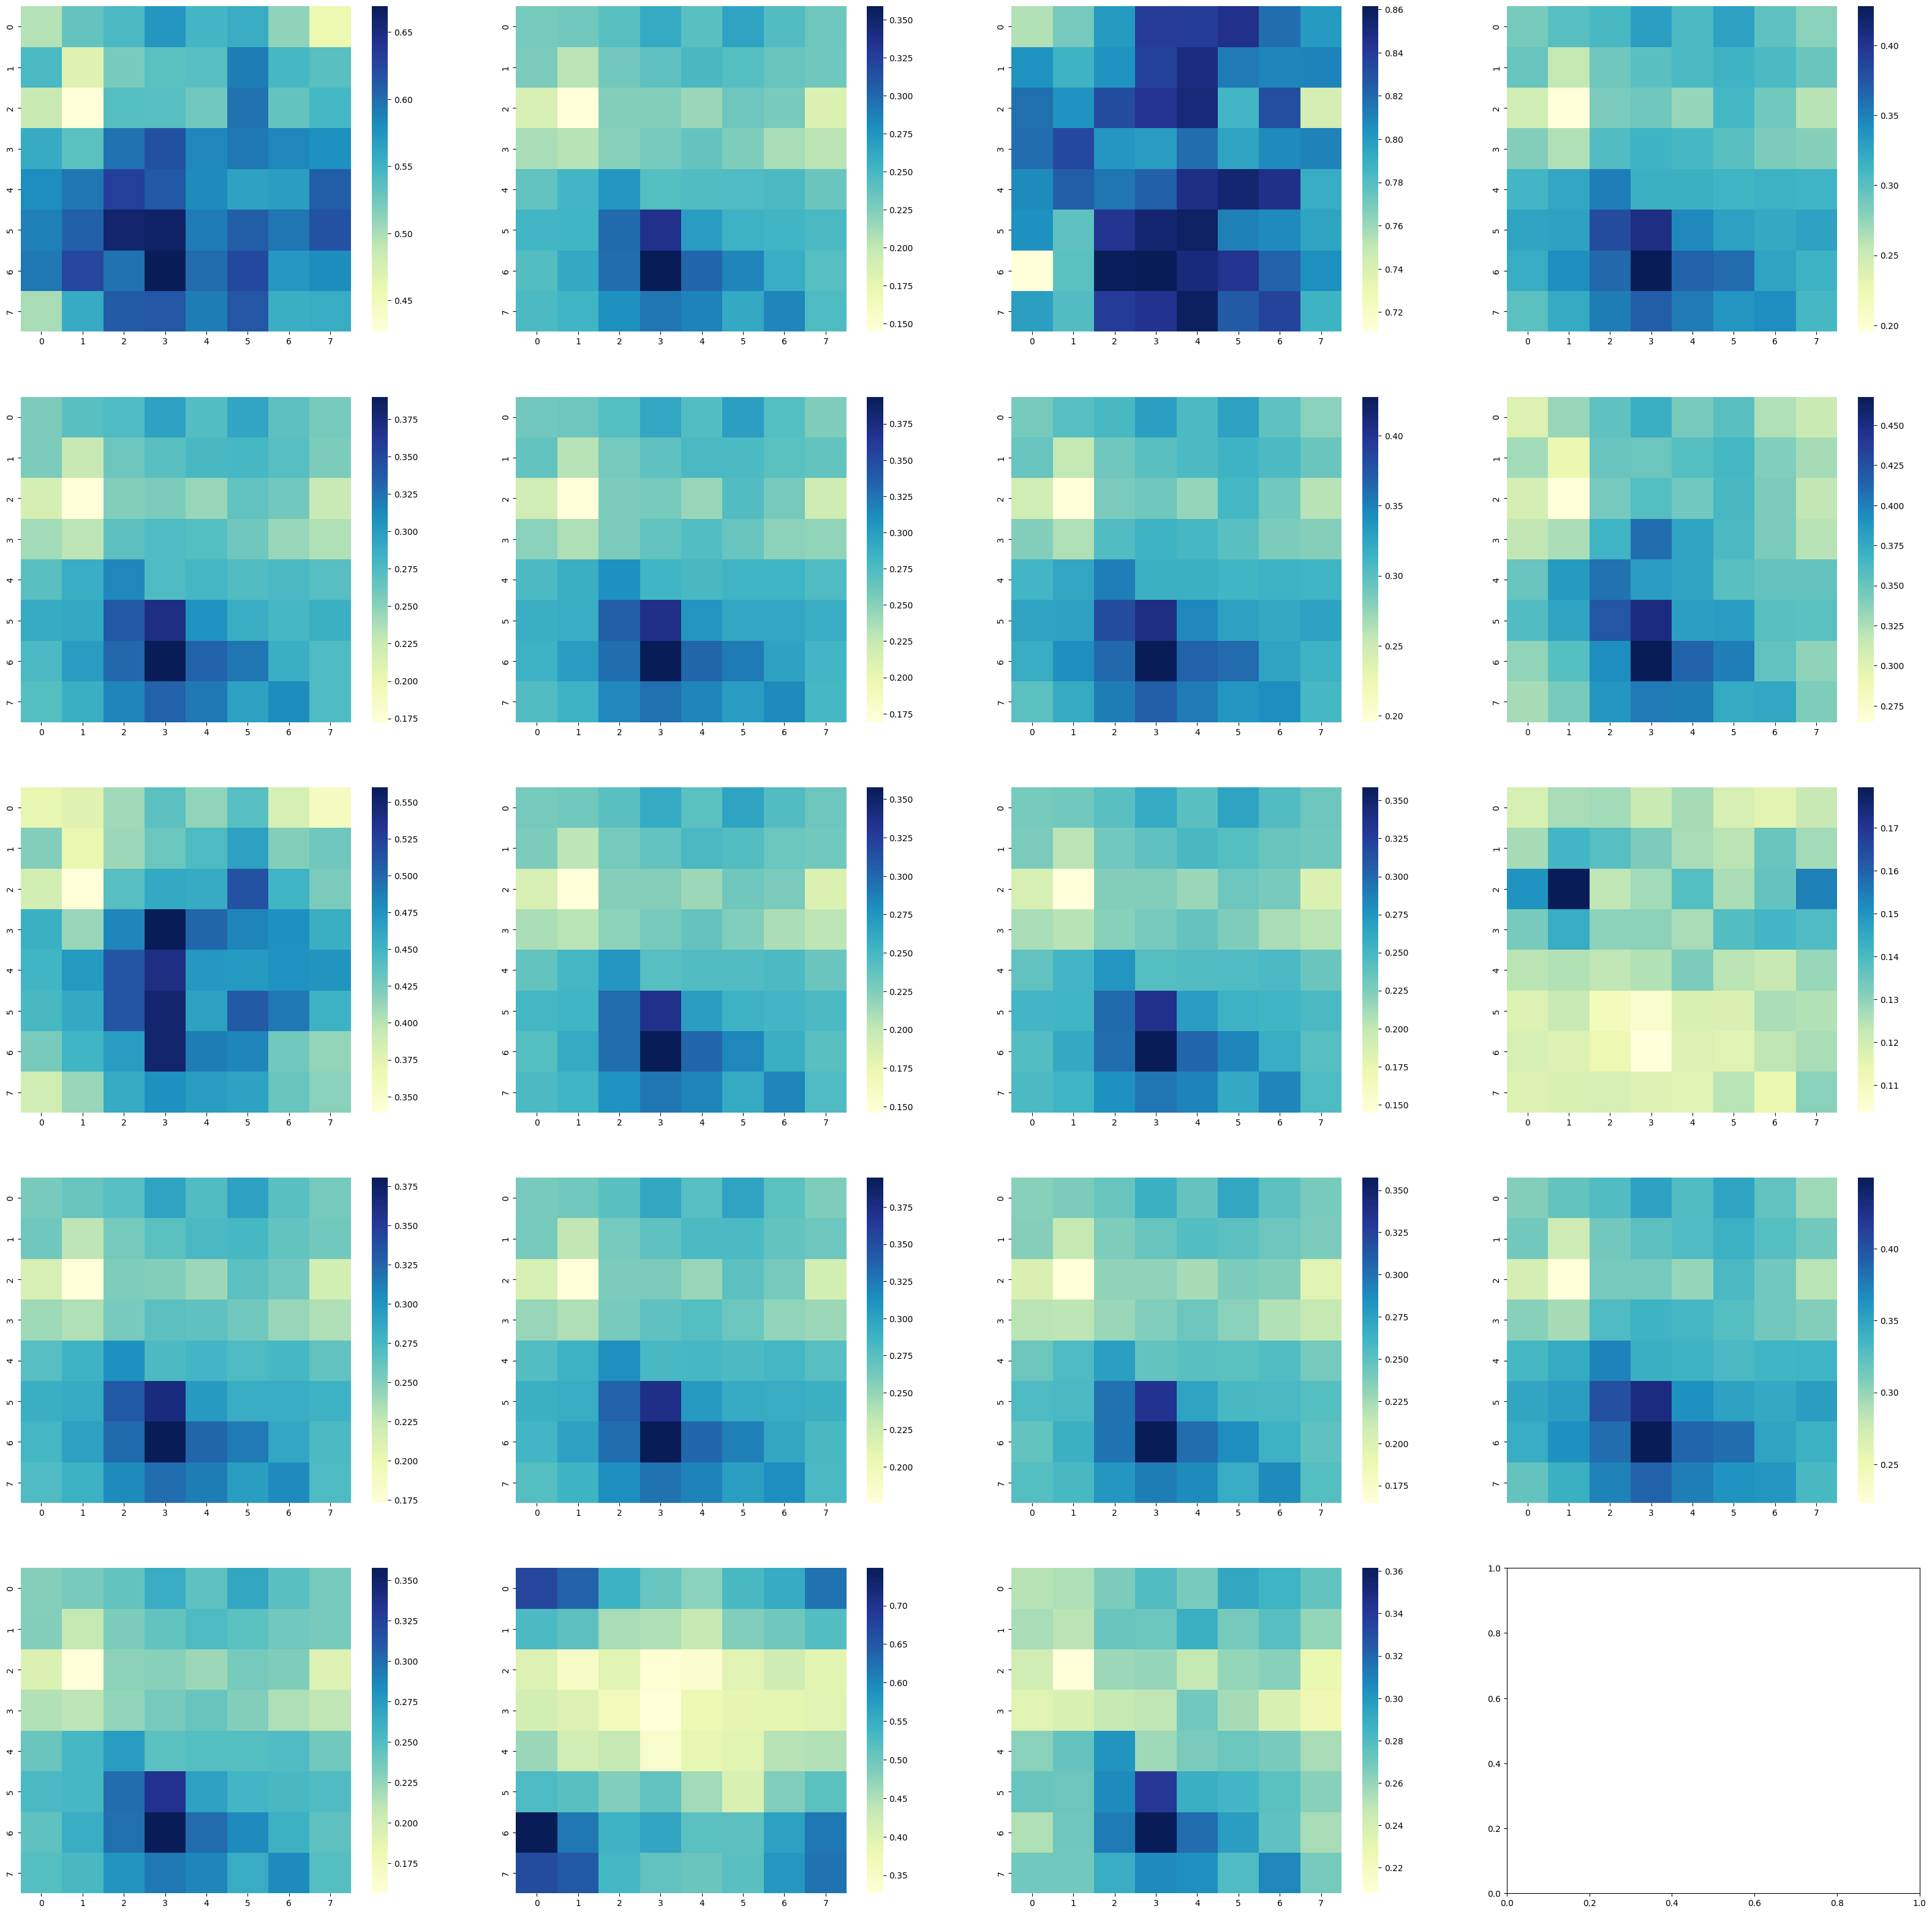

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [46]:
fig, ax = plt.subplots(5, 4, figsize=(40,40)) 

for it in range(19):
    
    cc = it % 4
    rr = it // 4
    
    label_features = data_train[:len(k_all)//config['max_n_step'],:,config['trans_mat_size']:]
    label_features = np.reshape(label_features, (-1, label_features.shape[-1]))
    risk_score_label = label_features[:,it]

    
    # Generate Heatmap
    som_dim = config['som_dim']
    f = plt.figure(figsize=(3,3))
    ones = np.ones((len(np.reshape(k_all, (-1)))))
    clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
    clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
    for i in range(som_dim[0]*som_dim[1]):
        s1 = np.sum(risk_score_label[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
        clust_matr1[i] = s1
    clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
    g = sns.heatmap(clust_matr1, cmap="YlGnBu", ax=ax[rr][cc])
    
plt.show()

## Case Study - II

### Config

In [47]:
pid = 854
max_n_step = 5
num_pred = 2
total_length = 13

In [50]:
labels_all_clustr = np.reshape(labels_all_clustr, (-1, labels_all_clustr.shape[-1]))
risk_score_label = labels_all_clustr[:,57]
# time_segments = time_segments.astype(int)
# labels = time_segments
som_dim = config['som_dim']
# f = plt.figure(figsize=(3,3))
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(risk_score_label[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))

### Trajectory

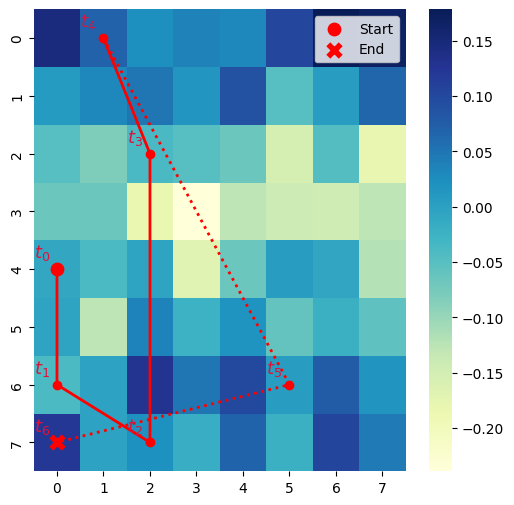

In [51]:
f = plt.figure(figsize=(6,6))

ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
k_1 = k_full_all[pid, -(max_n_step+num_pred):] // som_dim[1]
k_2 = k_full_all[pid, -(max_n_step+num_pred):] % som_dim[1]
cond_list = cond_full_all[pid, -(max_n_step+num_pred):]
# c='#8C000F'
c='r'

# Plotting solid line for input data
ax.plot(k_2[:max_n_step] + 0.5, k_1[:max_n_step] + 0.5, color=c, linewidth=2)

# Plotting dashed line for predition
ax.plot(k_2[-(num_pred+1):] + 0.5, k_1[-(num_pred+1):] + 0.5, color=c, linestyle='dotted', linewidth=2)

# Plotting Start, Intermediate and End Points
ax.scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=80, label='Start')
ax.scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=4, marker='.')
ax.scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=80, linewidth=4, marker='x', label='End')

# Plotting the state transitions
for i in range(max_n_step+num_pred):
    ax.annotate('$t_{'+str(i)+'}$', (k_2[i], k_1[i]+0.3), fontsize=13, color='crimson' ,fontweight='bold')
    

ax.legend(loc=1, prop={'size': 10})
plt.show()


### Explanability

#### 1. Attention over time_steps

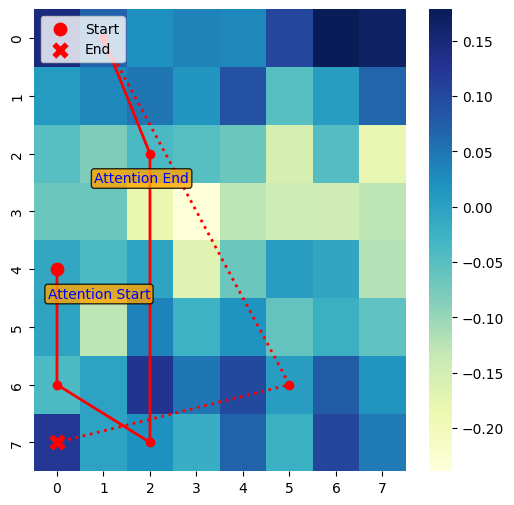

In [31]:
exp_report_for_pid = {}
for item in exp_report:
    if item['index']==pid:
        exp_report_for_pid.update(item)

ai_bs = exp_report_for_pid['attentive_index_for_burst_start']
ai_be = exp_report_for_pid['attentive_index_for_burst_end']


f = plt.figure(figsize=(6,6))

ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
k_1 = k_full_all[pid, -(max_n_step+num_pred):] // som_dim[1]
k_2 = k_full_all[pid, -(max_n_step+num_pred):] % som_dim[1]
cond_list = cond_full_all[pid, -(max_n_step+num_pred):]
c='r'

# Plotting solid line for input data
ax.plot(k_2[:max_n_step] + 0.5, k_1[:max_n_step] + 0.5, color=c, linewidth=2)

# Plotting dashed line for predition
ax.plot(k_2[-(num_pred+1):] + 0.5, k_1[-(num_pred+1):] + 0.5, color=c, linestyle='dotted', linewidth=2)

# Plotting Start, Intermediate and End Points
ax.scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=80, label='Start')
ax.scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=4, marker='.')
ax.scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=80, linewidth=4, marker='x', label='End')

# Plotting indexes for attention over TS.
ax.annotate("Attention Start", (k_2[ai_bs - (num_pred+max_n_step)]+0.3, k_1[ai_bs - (num_pred+max_n_step)]+1), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))
ax.annotate("Attention End", (k_2[ai_be - (num_pred+max_n_step-2)]-1+0.3, k_1[ai_be - (num_pred+max_n_step-2)]+1), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))

ax.legend(loc=2, prop={'size': 10})
plt.show()

#### 2. Features Responsible

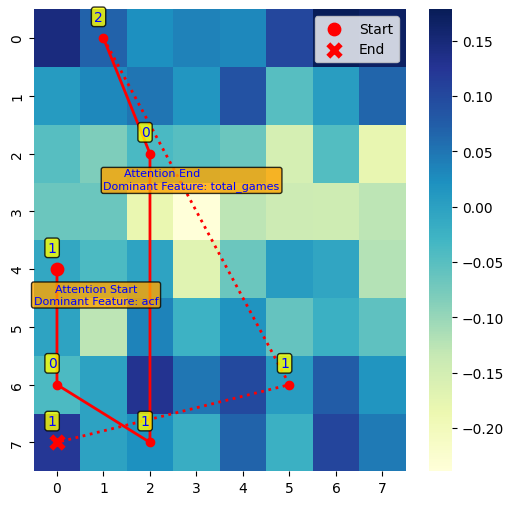

In [52]:
exp_report_for_pid = {}
for item in exp_report:
    if item['index']==pid:
        exp_report_for_pid.update(item)

cluster_imp_feat = get_imp_feature_from_cluster()
ai_bs = exp_report_for_pid['attentive_index_for_burst_start']
ai_be = exp_report_for_pid['attentive_index_for_burst_end']

f = plt.figure(figsize=(6,6))

ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
k_1 = k_full_all[pid, -(max_n_step+num_pred):] // som_dim[1]
k_2 = k_full_all[pid, -(max_n_step+num_pred):] % som_dim[1]

cond_list = cond_full_all[pid, :-max_n_step+1]
cond_list = cond_list[ -(max_n_step+num_pred):]
c='r'

# Plotting solid line for input data
ax.plot(k_2[:max_n_step] + 0.5, k_1[:max_n_step] + 0.5, color=c, linewidth=2)

# Plotting dashed line for predition
ax.plot(k_2[-(num_pred+1):] + 0.5, k_1[-(num_pred+1):] + 0.5, color=c, linestyle='dotted', linewidth=2)

# Plotting Start, Intermediate and End Points
ax.scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=80, label='Start')
ax.scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=4, marker='.')
ax.scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=80, linewidth=4, marker='x', label='End')

# Plotting the state transitions
for i, cond in enumerate(cond_list):
    ax.annotate(cond, (k_2[i]+0.3, k_1[i]+0.2), color='blue', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.8))

att_start_k = k_full_all[pid, ai_bs - 1] 
att_end_k = k_full_all[pid, ai_be + 1]

# Plotting Import features for  attentitive clusters.
ax.annotate("      Attention Start\nDominant Feature: "+cluster_imp_feat[att_start_k], (k_2[ai_bs - (num_pred+max_n_step)], k_1[ai_bs - (num_pred+max_n_step)]+1.1), color='blue', fontsize=8, bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8,))
ax.annotate("      Attention End\nDominant Feature: "+cluster_imp_feat[att_end_k], (k_2[ai_be - (num_pred+max_n_step-2)]-0.5, k_1[ai_be - (num_pred+max_n_step-2)]+1.1), color='blue', fontsize=8, bbox=dict(boxstyle='round,pad=0.2', fc='orange', alpha=0.8))

ax.legend(loc=1, prop={'size': 10})
plt.show()

#### 3. Dominant Features graphs across timesteps 

In [53]:
feature_name_dict

{0: 'Playtime_in_minutes',
 1: 'cat',
 2: 'cat_amount',
 3: 'cpc',
 4: 'cpc_size2',
 5: 'cpc_size6',
 6: 'total_games',
 7: 'fgl_2_player',
 8: 'fgl_6_player',
 9: 'total_modes',
 10: 'total_transactions',
 11: 'net_gain',
 12: 'lng',
 13: 'drop_count',
 14: 'invalid_dec_count',
 15: 'drop_adhere_count',
 16: 'acf',
 17: 'acf_amount',
 18: 'dld'}

In [54]:
cluster_imp_feat = get_imp_feature_from_cluster()

for i in range(config['input_size']):
    
    features_data = data_val_full[pid, -(max_n_step+num_pred):, config['trans_mat_size']+i]
    # Repective indexes for Dominant Features (acf_amount & acf)
    if i==16:
        print("Attention start point")
        x1 = features_data
        print(x1)
    if i==6:
        print("Attention end point")
        x2 = features_data
        print(x2)
        
        
# print(x1, x2)

Attention end point
[0.171 0.002 0.336 0.443 0.122 0.444 0.013]
Attention start point
[0.164 0.001 0.334 0.436 0.115 0.435 0.012]


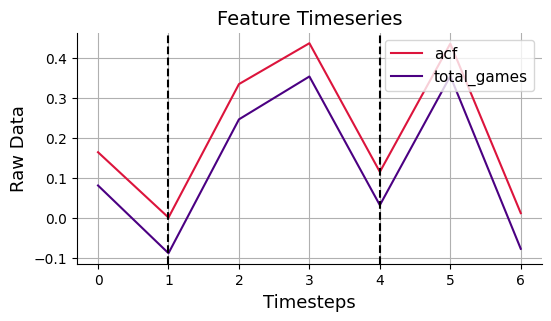

In [60]:
plt.figure(figsize=(6,3))
                    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.axis('off')
plt.plot(x1, color='crimson', label='acf')
plt.plot([i-0.09 for i in x2], color='indigo',  linestyle='solid', label='total_games')
# plt.plot(x2, color='b',  linestyle='dotted')
plt.legend(loc=1, prop={'size': 11})

plt.xlabel('Timesteps', fontsize=13)
plt.ylabel('Raw Data', fontsize=13)
plt.title('Feature Timeseries', fontsize=14)
plt.grid(True)

plt.axvline(1, color='k', linestyle='dashed')
plt.axvline(4, color='black', linestyle='dashed')
plt.show()
